**Option Pricing using Quantum Phase Estimation**

In this demo, we shall go through the steps involved in implementing option pricing using Quantum Phase Estimation. We will be using the classiq software development kit (SDK) for this purpose.



**Theoretical Background:**

*Financial options are contracts that give the holder the right (but not the obligation) to buy (call option) or sell (put option) a financial instrument (such as stocks) at a predetermined price (strike) before or at the expiration date.*

Let's understand this with a simple example: Suppose an option contract (containing a fixed number of shares of a certain stock) is bought when the underlying stock is worth $X$ with a target/strike price for the stock at $K$ (here $K>X$) and an expiration date of $3$ years. The buyer pays a premium to the seller to purchase this contract. Within these three years, the price of this option changes due to the stochastic nature of the stock prices underlying it. If on or before the period of $3$ years the stock price crosses the threshold of $K$ and reaches the price $S$ ($S$ is called the payoff and here $S>K$) the contract buyer exercises his right to buy the stock at the predetermined target price $Y$. In this process the buyer makes a profit of $S-K$ (minus the premium paid, for net profit). If the stock price remains below $K$ on or before the expiry date, the buyer won't exercise the contract and would suffer a loss of the premium amount paid to the seller.

The aim of option pricing is to figure out how much an option will be worth when it reaches its end date in the future.

**Expected Pay-off of an Option**
The expectation value of the payoff $E_P[f(X)]$ as an average across all prices paths is given by:
$$
\mathbb{E}_{\mathbb{P}}[f(\mathbf{X})]=\sum_{i=1}^{M} p_{i} f\left(\mathbf{X}_{i}\right)
$$
where $p_{i}$ is the probability of realizing the price path $i$. $\mathbf{X_i}$ is a column vector with $N$ rows (representing $N$ assets in the contract) and indicates a specific price path.

In [64]:
import numpy as np

#Theoretically calculated expected pay-off

probabilities= [0.20, 0.35, 0.25, 0.20] #probabilities of each price paths

k=70
s0= 50
Y= [0.9, 1.5, 1.75, 1.25]  # s0*Y[i] represents the possible price path for i in range(4)

pay_off_dist = [probabilities[x] * max(s0 * Y[x]- k , 0) for x in range(len(probabilities))] 

expected_expectation_value= np.sum(pay_off_dist) #E_P[f(X)]

print('EXPECTED PAYOFF:', expected_expectation_value)


EXPECTED PAYOFF: 6.125


Now, we'll utilize classiq SDK to evaluate this using quantum computation.

The first step is to install the latest version of classiq if not already working with the latest version.

In [ ]:
pip install -U classiq

The first step is to import all the necessary modules; some of the imported methods would be explained later while being used.

In [86]:
#Finance Model

#importing necessary modules 

import classiq
from classiq.builtin_functions import PiecewiseLinearAmplitudeLoading, PhaseEstimation
from classiq import QUInt, Model, synthesize, show, QReg, ControlState, execute,set_constraints
from classiq import FunctionGenerator, FunctionLibrary, RegisterUserInput
from classiq.builtin_functions import LinearPauliRotations, StatePreparation,AmplitudeEstimation, ArithmeticOracle, GroverOperator
from classiq.builtin_functions import XGate, UGate, ZGate
from classiq.model import Constraints, TranspilerBasisGates
from classiq.execution import ExecutionDetails
from classiq.execution import QaeWithQpeEstimationMethod
from classiq.model import Constraints, OptimizationParameter
import numpy as np
import matplotlib.pyplot as plt

The first steps in developing a quantum program in classiq is designing a quantum model- defining the algorithms, its constraints, and our preferences. 

Classiq platform enables us to build a quantum model from a **functional level** instead of a gate level. It has various built-in functions that can be directly used or we also build our own set of functions. *In Classiq, quantum algorithms are constructed from functions, which are the functional building blocks that implement quantum logic, and the data flow between them.*

Once our model is fully defined (the quantum program is described by using the `Model` object in classiq SDK), the next step is to synthesize it. The synthesis steps includes using the synthesize method on a SerializedModel that is received using the method `get_model()` of Model or from the content of .qmod file.



**Step 1: Preparing all the functional blocks**

The first function we shall define is the *state preparation* function. 

The first step involves loading the states into the quantum circuit. The states here are representative of possible option prices a option can take and the probabilities associated with the states represents the probability for a given option price. 

**Defining the state preparation function**

The function library is responsible for managing the data structure where all the user-defined functions are stored, as well as storing and managing all the required data. The first step is to create a function library. All our functions then created will be added to this library and then will be appropraitely called while implementing our algorithm. Instantiating the `FunctionGenerator` class will generate a function with the provided name.

In [87]:
qmci_library = FunctionLibrary()
function_generator =  FunctionGenerator(function_name="state_loading")

The inputs and outputs of the function are defined using the `create_inputs()` and `set_outputs()` methods of FunctionGenerator respectively. 

`create_inputs()` gets a dictionary as input, where the keys are the input names and the values are QReg type. The function returns a dictionary, where the keys are the input names, and the values are QReg objects of the requested type and size that can be used as an input of an inner function call.
`set_outputs()` gets a dictionary as input, where the keys are the output names and the values are QRegs returned by adding function calls to the FunctionGenerator instance.

The in-built `StatePreparation` function of Classiq generates a quantum program whose output state probabilities are an approximation to the PMF given. For example in the below code, the function prepares 4 states, the probability of state |000> is 0.20174669. 

In [88]:
sp_num_qubits = 2  

#number of possible option prices is equal to 2^{number of qubits}. Here we consider 4 possible option price paths

input_dict = function_generator.create_inputs({"io": QUInt[sp_num_qubits], "ind": QUInt[1]})

# probabilities= [0.20174669, 0.31564887, 0.29626157, 1- (0.20174669+0.31564887+0.29626157)]
probabilities= [0.20, 0.35, 0.25, 0.20]

#specifying the probabilities of 4 price paths- this has been taken from a log-normal distribution with mean = 0.01 and std_dev = 0.1

sp_params = StatePreparation(
    probabilities=probabilities, error_metric={"KL": {"upper_bound": 0.00}}
)

sp_output = function_generator.StatePreparation(
    params=sp_params, strict_zero_ios=False, in_wires={"IN": input_dict["io"]})
#the in_wires argument soecifies the input register to the StatePreparation operation

function_generator.set_outputs({"io": sp_output["OUT"], "ind": input_dict["ind"]})
qmci_library.add_function(function_generator.to_function_definition()) 
# the last line adds the function "state_loading" to the function library that can be later used. 


The next step is to load the pay-off function for the European Call Option with a specific strike price. For this we create another functional block named 'amp_load'. 

The payoff function to describe for example a European call option will be:

$f(S)=\
\Bigg\{\begin{array}{lr}
    0, & \text{when } K\geq S\\
    S - K, & \text{when } K < S\end{array}
$

This means that the option which was purchased with a target/strike price of $K$ will be profitable only when the future price of the option $S$ exceeds $K$ within the expiry of the option contract.

To load this linear pay-off function, we make use of classiq's inbuilt `PiecewiseLinearAmplitudeLoading` function. The AffineMap object, that has two attributes - offset and slope. For example, AffineMap(offset=a, slope=b) represents $f(x) = a + bx$. In this example $K=70$, hence for all the option prices below this level the payoff is $0$ indicated by the first element of the affine_map argument with offset=slope=0 and for option prices above this level the pay-off $f(s)= s-K$, hence offset= -K and slope=1. 

**Determining Breakpoints:** From $k=70, s0= 50, Y= [0.9, 1.5, 1.75, 1.25] $, the minimum value the asset can go upto is $0.9*50=45$ and the maximum value the asset can go upto is $1.75*50= 87.5$ and the strike is $70$, hence between 45 and 70, the payoff is $0$ and between 70 and 87.5, the payoff is $S-70$. Thus the breakpoints list would be $[45, 70, 87.5]$

The piecewise linear amplitude loading function performs the following operation:
$$
|d\rangle|0\rangle \rightarrow \sqrt{1-\tilde{f}(d)}|d\rangle|0\rangle+\sqrt{\tilde{f}(d)}|d\rangle|1\rangle
$$
for any input, $|d\rangle$, piecewise linear function $f(d)$. Where $\tilde{f}$ is a normalized and rescaled function of the given $f(d)$ :
$$
\tilde{f}(d)=2 \cdot \frac{cf(\phi(d))-f_{\min }}{f_{\max }-f_{\min }}-c+0.5
$$
and:
$$
\phi(d)=x_{\min }+\frac{x_{\max }-x_{\min }}{2^n-1} d
$$
$\boldsymbol{c}$ is the given rescaling factor. $\boldsymbol{f}_{\min }, \boldsymbol{f}_{\max }$ are the minimal and maximal values of the function in the given domain, and $x_{\min }, x_{\max }$ are the boundaries of the domain.

In [89]:
#Amplitude Loading block

function_generator = FunctionGenerator(function_name="amp_load")

input_dict = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

amplitude_loading_params = PiecewiseLinearAmplitudeLoading(
    num_qubits=2,
    breakpoints=[45, 70, 87.5],
    affine_maps=[{"offset": 0, "slope": 0}, {"offset": -70, "slope": 1}])

al_output = function_generator.PiecewiseLinearAmplitudeLoading(
    params=amplitude_loading_params, strict_zero_ios=False, in_wires={"state":input_dict["io"], "target": input_dict["ind"]}
)

# scaled_expectation_value = 0.5  # Probability of 1 after some execution
# expectation_value = amplitude_loading_params.compute_expectation_value(
#     scaled_expectation_value
# )
function_generator.set_outputs({"io": al_output["state"], "ind": al_output["target"]})

qmci_library.add_function(function_generator.to_function_definition())

Next, we will bring these two blocks together and define a single function that would represent $\boldsymbol{A}$. 

In [90]:
qmci_library = FunctionLibrary()
function_generator =  FunctionGenerator(function_name="state_amp_load")

sp_num_qubits = 2

#number of possible option prices is equal to 2^{number of qubits}. Here we consider 4 possible option price paths

input_dict = function_generator.create_inputs({"io": QUInt[sp_num_qubits], "ind": QUInt[1]})
# probabilities= [0.20174669, 0.31564887, 0.29626157, 1- (0.20174669+0.31564887+0.29626157)]
probabilities= [0.20, 0.35, 0.25, 0.20]

#specifying the probabilities of 4 price paths- this has been taken from a log-normal distribution with mean = 0.01 and std_dev = 0.1

sp_params = StatePreparation(
    probabilities=probabilities, error_metric={"KL": {"upper_bound": 0.00}}
)

sp_output = function_generator.StatePreparation(
    params=sp_params, strict_zero_ios=False, in_wires={"IN": input_dict["io"]})
#the in_wires argument soecifies the input register to the StatePreparation operation

amplitude_loading_params = PiecewiseLinearAmplitudeLoading(
    num_qubits=2,
    breakpoints=[45, 70, 87.5],
    affine_maps=[{"offset": 0, "slope": 0}, {"offset": -70, "slope": 1}])

al_output = function_generator.PiecewiseLinearAmplitudeLoading(
    params=amplitude_loading_params, strict_zero_ios=False, in_wires={"state":sp_output["OUT"], "target": input_dict["ind"]}
)
function_generator.set_outputs({"io": al_output["state"], "ind": al_output["target"]})

qmci_library.add_function(function_generator.to_function_definition())

Now we're ready to perform Quantum Amplitude Estimation. Let's say we have a unitary operator $A$ acting on a register of $(n+1)$ qubits such that \begin{equation}
A |0>_{n+1}= |\Psi>= \sqrt {1-a}|\psi_{0}>_{n}|0> + \sqrt{a}|\psi_{1}>_{n}|1> \end{equation} where $|\psi_{0}>_{n}$ and $|\psi_{1}>_{n}$ are some $n$-qubit normalized states and $a\in [0,1]$ is unknown and with AE we need to efficiently estimate $a$.
We use the Grover Operator defined by $Q= A S_{0} A^{\dagger} S_{|\psi_{0}>}$, where $S_{0}= 1- 2|0><0|$ and $S_{|\psi_{0}}>= 1- 2|\psi_{0}>|{0}><\psi_{0}|<0|$, represent the reflection operators about the state $|0>$ and the good state $|\psi_{0}>$ respectively. The full action of the operator $Q$ is to rotate the state $A |0>_{n+1}$ by an angle $2\theta$ in the $2D$ space spanned by $|\psi_{0}>_{n}|0>$ and $|\psi_{1}>_{n}|1>$, where $a= \sin^{2}{(\theta)}$. 


The algorithm $A$ in our case consists of both the stateloading and the amplitude loading part. For an option with payoff $f$, let's suppose the $\mathcal{A}$ operator creates the following state: 

\begin{equation}\label{eq:main}
\sum_{i=0}^{2^{n}-1} \sqrt{1-\tilde{f}\left(d_{i}\right)} \sqrt{p_{i}}\left|d_{i}\right\rangle|0\rangle+\sum_{i=0}^{2^{n}-1} \sqrt{\tilde{f}\left(d_{i}\right)} \sqrt{p_{i}}\left|d_{i}\right\rangle|1\rangle .
\end{equation}
where $d_{i}$ represent the possible values the underlying asset can take and the corresponding probabilities are $p_{i}$. Here we have assumed that the prices can take $2^{n}$ possible values on expiration and on a quantum circuit $n$ qubits can be used to represent all these price paths. Note that from the second term its possible to retrieve the required expectation value.

The probability to find the ancilla qubit in state $|1\rangle$, is given by $$P_{1} = \sum_{i=0}^{2^{n}-1} p_{i}\left(c \tilde{f}(i)+\frac{1}{2}\right)=c (\frac{2 \mathbb{E}[f(X)]-f_{\min }}{f_{\max }-f_{\min }})-c+\frac{1}{2}$$

Thus we could recover $\mathbb{E}[\max (0, i-K)]$ from $P_{1}$ up to a scaling factor and a constant.


**Implementing the Grover's operator as a Composite function in Classiq**

The Grover's operator consists of essentially $3$ parts- Reflection about the good state ($S_{|\psi_{0}>}$), Reflection about the zero state ($S_{0}$) and the algorithm $A$

The good state oracle in this case should be an operation that flips the sign of the good state, here the state being the one with ancilla qubit $|1>$. Thus a Z-gate on the "ind" register will achieve the desired outcome. 

In [92]:
# Good State Oracle

function_generator = FunctionGenerator(function_name="good_state_oracle")

input_dict = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

z_out = function_generator.ZGate(
    params=ZGate(),
    in_wires={"TARGET": input_dict["ind"]},
)

function_generator.set_outputs({"ind": z_out["TARGET"], "io": input_dict["io"]})
qmci_library.add_function(function_generator.to_function_definition())

The next part in the Grover's operator includes reflection about the zero state. The operator action is to flip the sign of the state if its a zero state and do nothing otherwise. Consider a general state of $(n+1)$ qubits. We choose an arbitrary qubit, say the first one. We would like to apply a $(-Z)$ Gate on it, controlled by all the rest of the $n$ qubits being at state zero. This is exactly the functionality we would like to achieve for implementing reflection about the zero state. Note that this function is a generic one, independent of the specific problem and partitioning to io and ind registers. We thus define a generic zero_oracle function, having $n+1$ sized input and output registers, which we designate with the name mcz_io.

In [93]:
# Function representing reflection about the zero state

function_generator = FunctionGenerator(function_name="zero_oracle")

reg_size = sp_num_qubits + 1
input_dict = function_generator.create_inputs({"mcz_io": QUInt[reg_size]})

x_out = function_generator.XGate(
    params=XGate(),
    in_wires={"TARGET": input_dict["mcz_io"][0]},
    should_control=False,
)

control_states = ControlState(ctrl_state="0" * (reg_size - 1), name="ctrl_reg")

mcz_out = function_generator.ZGate(
    params=ZGate(),
    control_states=control_states,
    in_wires={"TARGET": x_out["TARGET"], "ctrl_reg": input_dict["mcz_io"][1:reg_size]},
)

x_out = function_generator.XGate(
    params=XGate(), in_wires={"TARGET": mcz_out["TARGET"]}, should_control=False
)

function_generator.set_outputs(
    {"mcz_io": QReg.concat(x_out["TARGET"], mcz_out["ctrl_reg"])}
)

qmci_library.add_function(function_generator.to_function_definition())

**Implementing the complete Grover Operator**

We can now define a complete Grover operator $Q \equiv- A S_0 A^{\dagger} S_{\psi_1} $. Some points of emphasis are as follows:
1. The operation of $\boldsymbol{A}^{\dagger}$ is done by calling $\boldsymbol{A}$ and raising the flag is_inverse=True .
2. We pass should_control=False for $\boldsymbol{A}$ and $\boldsymbol{A}^{\dagger}$.
3. When wiring from $\boldsymbol{A}^{\dagger}$ to $S_0$ we use concatenation of the $\boldsymbol{n}$-sized ( io ) and singlesized ( ind ) registers into the $(n+1)$-sized mcz_io register.
4. When wiring from $S_0$ to $A$ we use the corresponding opposite call of register slicing, from mcz_io to io and ind.
5. We add a global phase of -1 to the full operator, by using the built-in UGate .

In [94]:
function_generator = FunctionGenerator(function_name="grover")
function_generator.include_library(qmci_library)


in_wires = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

oracle_out = function_generator.good_state_oracle(in_wires=in_wires)

sps_inverse_out = function_generator.state_amp_load(
    in_wires={"io": oracle_out["io"], "ind": oracle_out["ind"]},
    is_inverse=True,
    should_control=False,
)

zero_oracle_out = function_generator.zero_oracle(
    in_wires={"mcz_io": QReg.concat(sps_inverse_out["io"], sps_inverse_out["ind"])}
)


sps_out = function_generator.state_amp_load(
    in_wires={
        "io": zero_oracle_out["mcz_io"][0:sp_num_qubits],
        "ind": zero_oracle_out["mcz_io"][sp_num_qubits],
    },
    should_control=False,
)


global_phase_out = function_generator.UGate(
    UGate(theta=0, phi=0, lam=0, gam=np.pi), in_wires={"TARGET": sps_out["ind"]}
)
#this operation takes care of the minus sign in the Grover operator

function_generator.set_outputs({"io": sps_out["io"], "ind": global_phase_out["TARGET"]})


qmci_library.add_function(function_generator.to_function_definition())

Now we apply a basic AE algorithm which is based on QPE. The idea behind this Algorithm is the following:

The state $\boldsymbol{A}|\mathbf{0}\rangle_{\boldsymbol{n}}|\mathbf{0}\rangle$ is spanned by two eigenvectors of our Grover operator $Q$, with the two corresponding eigenvalues
$$
\lambda_{ \pm}=\exp ( \pm i 2 \pi \theta), \quad \sin ^2( \theta) \equiv a .
$$

That is, the action of $Q$ on $|\Psi\rangle$ is,
$$
Q|\Psi\rangle= a_1 e^{+i2\theta}|\psi_+\rangle + a_2 e^{-i2\theta}|\psi_-\rangle
$$

where $|\psi_+\rangle$ and $|\psi_-\rangle$ are eigenvectors of the Grover operator $Q$ 

Denote $2 \theta = \frac{2\pi q}{2^{m}}$, where $m$ is the size of the estimation register in the QPE algorithm.

Now applying Quantum Phase Estimation,

$$ QPE(|0\rangle|\Psi\rangle)= a_1|q\rangle|\psi_+\rangle + a_2 |q + 2^{m-1}\rangle|\psi_-\rangle $$

Note that the phases corresponding to the eigenvectors  $|\psi_+\rangle$ and $|\psi_-\rangle$ differ by angle $\pi$; hence the term $|q + 2^{m-1}\rangle$ in the above expression makes sense as,
$$\frac{2\pi( q+ 2^{m-1})}{2^{m}}= \frac{2\pi q}{2^{m}} + \pi$$
If upon measurement of the estimation register we obtain $q'$ and $q'> 2^{m-1}$ then we get the phase corresponding to $|\psi_-\rangle$ branch, hence our estimated $q$ (say $q_p$) from the QPE algorithm is, $$ q_p= q' - 2^{m-1} $$

Thus the value of $2\theta$ is $ \frac{2\pi q_p}{2^{m}}$ and hence the the value of $a$ is simply,

$$a= \sin^{2}{\theta}= \sin^{2}(\frac{\pi q_p}{2^{m}})$$
This result is exact, for the case where $q_p$ is an integer.

Thus in summary, if we apply a QPE on $|\psi\rangle= \boldsymbol{A}|\mathbf{0}\rangle_{\boldsymbol{n}}|\mathbf{0}\rangle$ we will have these two eigenvalues encoded in the QPE register, however, both give the value of $a$, so there is no ambiguity here.

To find $\boldsymbol{a}$ we are going to build a simple quantum model: we apply $\boldsymbol{A}$ on a quantum register of size $\boldsymbol{n}+\mathbf{1}$ initialized to zero, and then apply Classiq's QPE [QPE] with our user-defined Grover operator.

Below, we build our model, define its output, and synthesize it. In particular, we define the output phase_result which holds the phase register of the QPE. We choose a QPE with phase register of size 3, governing the accuracy of our Phase-, and thus Amplitude-, Estimation. The way to pass our user defined function to the QPE is through the unitary and unitary_params parameters as follows:

In [96]:
#APPLYING AMPLITUDE ESTIMATION (AE) WITH QUANTUM PHASE ESTIMATION (QPE)

n_qpe = 4
constraints = Constraints(
    max_width=23,
    max_depth=5000,
)

model = Model()
model.include_library(qmci_library)
sp_output = model.state_amp_load() 

qpe_out = model.PhaseEstimation(
    params=PhaseEstimation(
        size=n_qpe, unitary_params=qmci_library.get_function("grover"), unitary="grover"
    ),
    in_wires={"io": sp_output["io"], "ind": sp_output["ind"]},
)
# qae_params = AmplitudeEstimation(
#     grover_operator=qmci_library.get_function("grover"),
#     estimation_register_size=n_qpe
# )
# qae_out= model.AmplitudeEstimation(params=qae_params,in_wires={"io": sp_output["io"], "ind": sp_output["ind"]})

# model.set_outputs({"phase": qae_out_wires["ESTIMATED_AMPLITUDE_OUTPUT"]})
# model.sample()
# model.post_process_amplitude_estimation(
#     estimation_register_size=3, estimation_method=QaeWithQpeEstimationMethod.BEST_FIT
# )

model.set_outputs({"phase_result": qpe_out["PHASE_ESTIMATION"]})
serialized_model = model.get_model()
serialized_model_constraints = set_constraints(serialized_model, constraints)
qprog= synthesize(serialized_model_constraints)
show(qprog)

Opening: https://platform.classiq.io/circuit/d3d71073-9622-4dc8-986a-5aecf229af89?version=0.35.0


A: [SampledState(state={'phase_result': 8.0}, shots=277), SampledState(state={'phase_result': 13.0}, shots=244), SampledState(state={'phase_result': 3.0}, shots=225), SampledState(state={'phase_result': 11.0}, shots=174), SampledState(state={'phase_result': 5.0}, shots=134), SampledState(state={'phase_result': 9.0}, shots=124), SampledState(state={'phase_result': 1.0}, shots=120), SampledState(state={'phase_result': 4.0}, shots=116), SampledState(state={'phase_result': 0.0}, shots=114), SampledState(state={'phase_result': 7.0}, shots=111), SampledState(state={'phase_result': 15.0}, shots=109), SampledState(state={'phase_result': 12.0}, shots=97), SampledState(state={'phase_result': 10.0}, shots=78), SampledState(state={'phase_result': 6.0}, shots=71), SampledState(state={'phase_result': 2.0}, shots=28), SampledState(state={'phase_result': 14.0}, shots=26)]
B: {0.5: 277, 0.8125: 244, 0.1875: 225, 0.6875: 174, 0.3125: 134, 0.5625: 124, 0.0625: 120, 0.25: 116, 0.0: 114, 0.4375: 111, 0.937

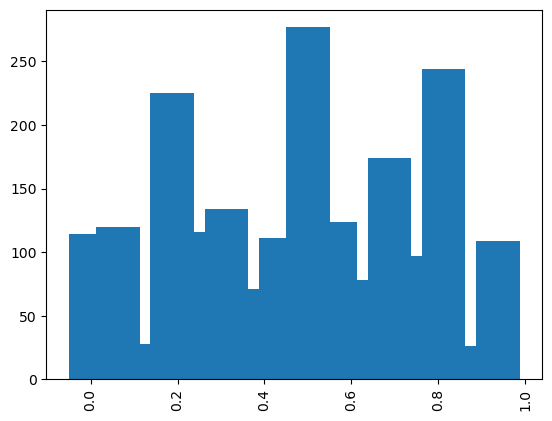

phase with max probability:  0.5
measured amplitude/PAYOFF:  1.0


In [97]:
results = execute(qprog).result()

from classiq.execution import ExecutionDetails

res = results[0].value

# print(res)

phases_counts = res.parsed_counts #The counts for the phases stored in the phase_result are given in res.parsed_counts

print('A:', phases_counts)

## mapping between register string to phases
phases_counts = dict(
    (sampled_state.state["phase_result"] / 2**n_qpe, sampled_state.shots)
    for sampled_state in res.parsed_counts
)

print('B:', phases_counts)

plt.bar(phases_counts.keys(), phases_counts.values(), width=0.1)
plt.xticks(rotation=90)
plt.show()
print("phase with max probability: ", max(phases_counts, key=phases_counts.get))

print(
    "measured amplitude/PAYOFF: ",
    np.sin(np.pi * max(phases_counts, key=phases_counts.get)) ** 2,
)

In [52]:
# import math

# expected_pay_off= (((1+ (((math.pi)/4)-0.5))/((math.pi)/4))*17.5)/2
# print(expected_pay_off)


14.320423008216336


In [98]:
scaled_expectation_value = 1  # Probability of 1 after some execution
expectation_value = amplitude_loading_params.compute_expectation_value(
    scaled_expectation_value
# )
print(expectation_value)

13.911268065124442


In [ ]:

state_amp= qmci_library.get_function('state_amp_load')

oracle_params = ArithmeticOracle(
    expression="ind == 1",
    definitions={"ind": RegisterUserInput(size= 1)}
# state_preparation_params = StatePreparation(
#     probabilities=[0.15, 0.19, 0.11, 0.27, 0, 0.01, 0, 0.27],
#     error_metric={"KL": {"upper_bound": 0}},
# )
grover_operator_params = GroverOperator(
    oracle_params=oracle_params,
    state_preparation_params='state_amp_load',
)
    
qae_params = AmplitudeEstimation(grover_operator=grover_operator_params, estimation_register_size=3)


# The model
model = Model()
model.sample()

sp_output = model.state_amp_load()

grover_dict = model.GroverOperator(
    params=grover_operator_params, in_wires={"io": sp_output["io"], "ind": sp_output["ind"]}
)

qae_out_wires = model.AmplitudeEstimation(params=qae_params, in_wires={"io": sp_output["io"], "ind": sp_output["ind"]})
model.set_outputs({"phase": qae_out_wires["ESTIMATED_AMPLITUDE_OUTPUT"]})
model.sample()
model.post_process_amplitude_estimation(
    estimation_register_size=3, estimation_method=QaeWithQpeEstimationMethod.BEST_FIT
)